# Facial Emotion Recogination

 dataset: https://www.kaggle.com/datasets/msambare/fer2013

## Importing the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from keras.utils import plot_model
import seaborn as sns

## Loading the dataset

In [2]:
working_dir = os.getcwd()
print(working_dir)

/Users/amit/Movies/Project_Music


In [3]:
train_dir =  working_dir + '/fer2013/train/'
test_dir = working_dir + '/fer2013/test/'

In [4]:
row, col = 48, 48
classes = 7

### Creating a function for returning the number of files in each directory

In [5]:
def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        if expression != '.DS_Store':  # Skip non-directory files
            dir_ = os.path.join(path, expression)
            dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df

In [6]:
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print("\n\n")
print(test_count)

       happy   sad  fear  surprise  neutral  angry  disgust
train   7215  4830  4097      3171     4965   3995      436



      happy   sad  fear  surprise  neutral  angry  disgust
test   1774  1247  1024       831     1233    958      111


### Plotting the number of images in training set

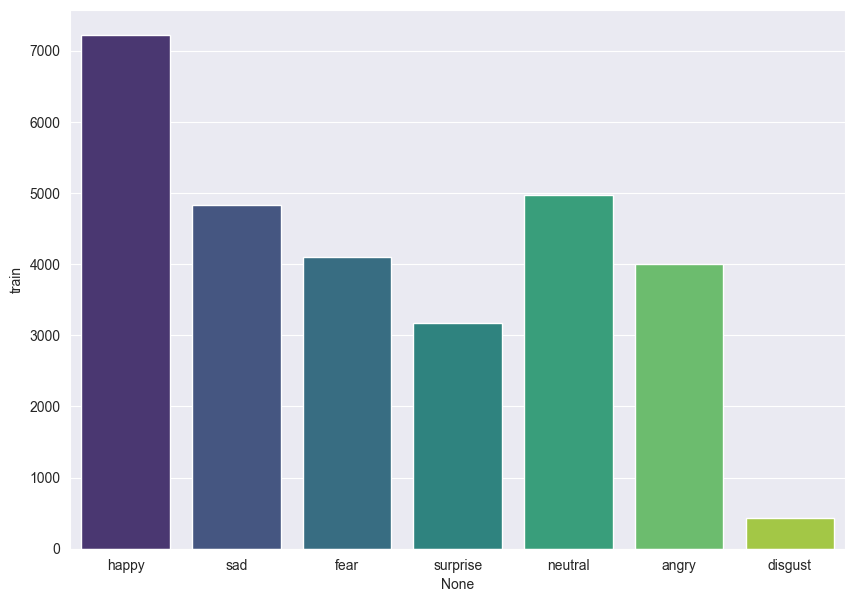

In [7]:
train_count_trans = train_count.transpose()
sns.set_style('darkgrid')
plt.figure(figsize=(10, 7))
sns.barplot(x=train_count_trans.index, y=train_count_trans.train, hue=train_count_trans.index, palette='viridis', legend=False)
plt.show()

### Plotting the number of images in test set

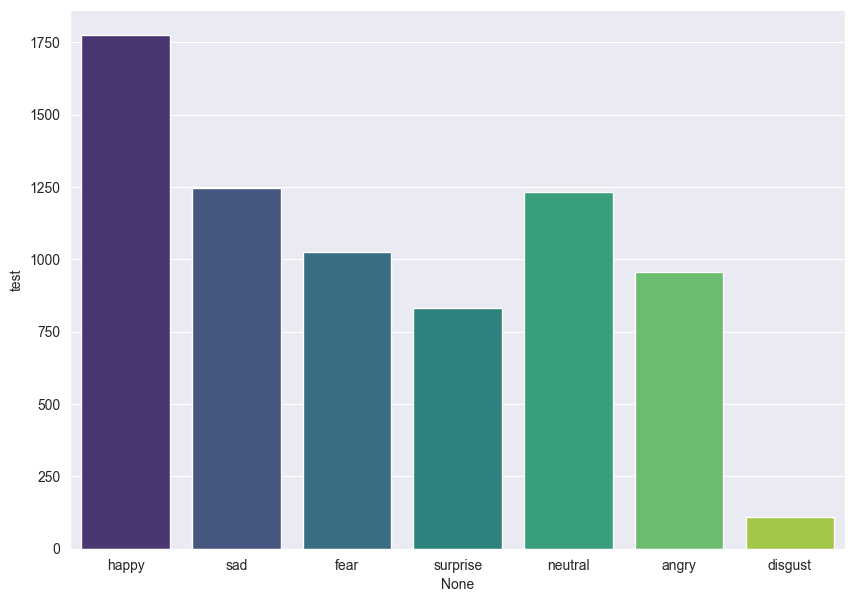

In [8]:
sns.set_style('darkgrid')
test_count_trans = test_count.transpose()
plt.figure(figsize=(10, 7))
sns.barplot(data=test_count_trans, x=test_count_trans.index, y="test", hue=test_count_trans.index, palette="viridis", legend=False)
plt.show()

# Data Visualisation 

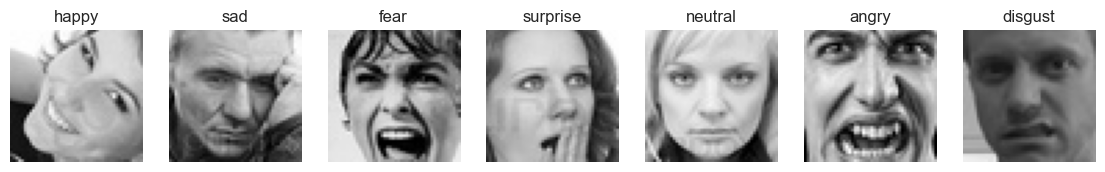

In [9]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[19]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

# Data Preprocessing

### Preparing the training set

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir, batch_size=64, target_size=(48,48), shuffle=True, color_mode='grayscale', class_mode='categorical')

Found 28709 images belonging to 7 classes.


### Preparing the test set

In [11]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_set = test_datagen.flow_from_directory(test_dir, batch_size=64, target_size=(48,48), shuffle=True, color_mode='grayscale', class_mode='categorical')

Found 7178 images belonging to 7 classes.


### Defining the class labels

In [12]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

# Model Building

In [13]:
def create_model(input_size, classes=7):
    model = tf.keras.models.Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(classes, activation='softmax'))

    # Compile the model with the updated Adam optimizer
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

my_model = create_model((row, col, 1), classes)

In [14]:
my_model = create_model((row,col,1), classes)
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_2 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 128)      

In [15]:
plot_model(my_model, to_file='my_model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Defining the Callback Functions

In [16]:
chk_path = 'my_model.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path, save_best_only=True, verbose=1, mode='min', moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss',  min_delta=0,  patience=3,  verbose=1,  restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=6, verbose=1, min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

# Model Training

In [83]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = my_model.fit(x=training_set, validation_data=test_set, epochs=60, callbacks=callbacks, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/60
448/448 [==============================] - ETA: 0s - loss: 4.2438 - accuracy: 0.2737
Epoch 1: val_loss improved from inf to 9.83961, saving model to my_model.h5


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


448/448 [==============================] - 201s 448ms/step - loss: 4.2438 - accuracy: 0.2737 - val_loss: 9.8396 - val_accuracy: 0.1436 - lr: 1.0000e-04
Epoch 2/60
448/448 [==============================] - ETA: 0s - loss: 3.3987 - accuracy: 0.3340
Epoch 2: val_loss improved from 9.83961 to 3.01046, saving model to my_model.h5
448/448 [==============================] - 222s 496ms/step - loss: 3.3987 - accuracy: 0.3340 - val_loss: 3.0105 - val_accuracy: 0.3936 - lr: 1.0000e-04
Epoch 3/60
448/448 [==============================] - ETA: 0s - loss: 2.8747 - accuracy: 0.3723
Epoch 3: val_loss improved from 3.01046 to 2.59148, saving model to my_model.h5
448/448 [==============================] - 243s 542ms/step - loss: 2.8747 - accuracy: 0.3723 - val_loss: 2.5915 - val_accuracy: 0.4116 - lr: 1.0000e-04
Epoch 4/60
448/448 [==============================] - ETA: 0s - loss: 2.4785 - accuracy: 0.4040
Epoch 4: val_loss improved from 2.59148 to 2.19962, saving model to my_model.h5
448/448 [=======

## Plotting graphs for Model Loss and Model Accuracy

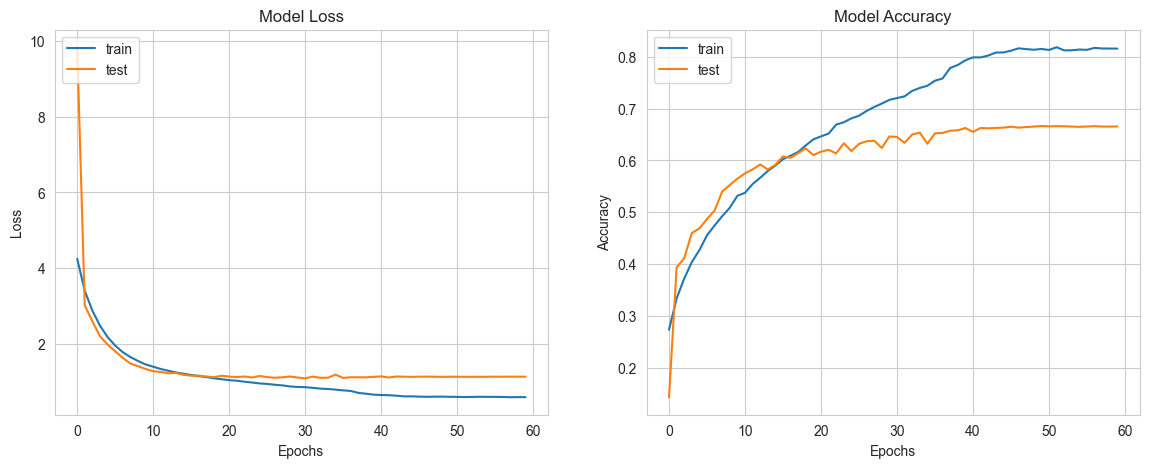

In [84]:
sns.set_style('whitegrid')
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Observations:**

Here we can see that the model has achieved a decent accuracy on the training set but the accuracy on the test/validation set is about 66%. Also we can see that no overfitting is present in the model. Thus we can conclude that the poor performance on the validation set is due the unbalanced dataset.

# Model evaluation

In [85]:
train_loss, train_accu = my_model.evaluate(training_set)
test_loss, test_accu = my_model.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 13s 113ms/step - loss: 1.1293 - accuracy: 0.6654
final train accuracy = 89.47 , validation accuracy = 66.54


In [86]:
my_model.save_weights('my_model.h5')

### Confusion Matrix and Classification on training set

In [17]:
from tensorflow.keras.models import load_model
my_model = load_model('my_model.h5')

In [18]:
y_pred = my_model.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

449/449 [==============================] - 50s 111ms/step


In [19]:
from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)

Confusion Matrix
[[ 482    0   87 1909  702  351  464]
 [  51    0    9  211   86   45   34]
 [ 515    0   86 1828  774  410  484]
 [ 862    0  183 3311 1304  687  868]
 [ 610    0  112 2218  903  490  632]
 [ 604    0   86 2258  869  449  564]
 [ 415    0   86 1409  582  315  364]]


In [21]:
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.12      0.13      3995
     disgust       0.00      0.00      0.00       436
        fear       0.13      0.02      0.04      4097
       happy       0.25      0.46      0.33      7215
     neutral       0.17      0.18      0.18      4965
         sad       0.16      0.09      0.12      4830
    surprise       0.11      0.11      0.11      3171

    accuracy                           0.19     28709
   macro avg       0.14      0.14      0.13     28709
weighted avg       0.17      0.19      0.17     28709



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

([<matplotlib.axis.YTick at 0x311a28850>,
 [Text(0, 0, 'angry'),
  Text(0, 1, 'disgust'),
  Text(0, 2, 'fear'),
  Text(0, 3, 'happy'),
  Text(0, 4, 'neutral'),
  Text(0, 5, 'sad'),
  Text(0, 6, 'surprise')])

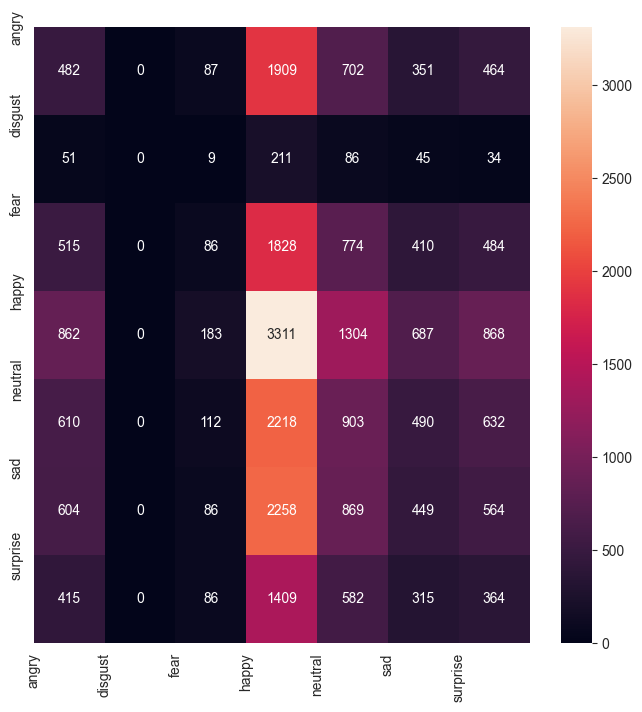

In [22]:
plt.figure(figsize=(8,8))
sns.heatmap(cm_train, annot = True, fmt = 'g')
tick_mark = np.arange(len(target_names))
plt.xticks(tick_mark, target_names, rotation=90)
plt.yticks(tick_mark, target_names)

### Confusion Matrix and Classification on test set

In [23]:
y_pred = my_model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix

113/113 [==============================] - 12s 108ms/step


In [24]:
cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)


Confusion Matrix
[[157   0  33 368 159  71 170]
 [ 11   0   3  47  21  13  16]
 [157   0  31 425 176  82 153]
 [273   0  57 754 269 150 271]
 [204   0  46 486 208 104 185]
 [184   0  58 512 178 115 200]
 [143   0  27 352 138  66 105]]


([<matplotlib.axis.YTick at 0x311bada50>,
 [Text(0, 0, 'angry'),
  Text(0, 1, 'disgust'),
  Text(0, 2, 'fear'),
  Text(0, 3, 'happy'),
  Text(0, 4, 'neutral'),
  Text(0, 5, 'sad'),
  Text(0, 6, 'surprise')])

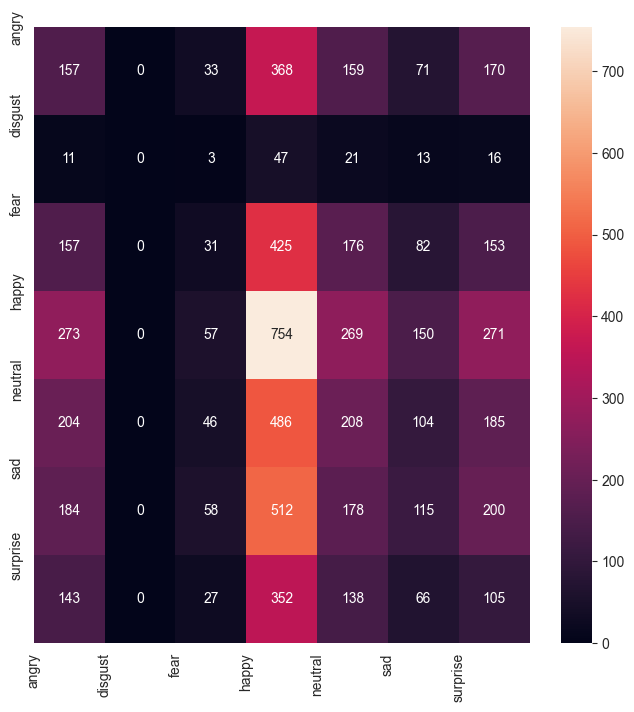

In [25]:
plt.figure(figsize=(8,8))
sns.heatmap(cm_test, annot = True, fmt = 'g')
tick_mark = np.arange(len(target_names))
plt.xticks(tick_mark, target_names, rotation=90)
plt.yticks(tick_mark, target_names)

In [30]:
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.16      0.15       958
     disgust       0.00      0.00      0.00       111
        fear       0.12      0.03      0.05      1024
       happy       0.26      0.43      0.32      1774
     neutral       0.18      0.17      0.17      1233
         sad       0.19      0.09      0.12      1247
    surprise       0.10      0.13      0.11       831

    accuracy                           0.19      7178
   macro avg       0.14      0.14      0.13      7178
weighted avg       0.17      0.19      0.17      7178



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.